In [3]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
import matplotlib.pyplot as plt
import seaborn as sns

#Prepare Data
df = pd.read_csv("/kaggle/input/quote-2019/Quote.csv")
#print(df.describe())
# 2. Remove rows with NA values
print(df.shape)
# Only keep the target variable 'payoff_sum'
df = df.iloc[:, 7:]
# Remove the 'mood' column
df = df.iloc[:, :-1]
# Remove anomalous data
df = df.replace('/', float('nan'))  # unify '/' to NaN
df = df.replace('7-8', float('nan'))
df = df.dropna()                     # drop all rows containing NaN
df = df.astype(float)
print(df.shape)


(111, 38)
(106, 30)


In [5]:
def standardize_dataframe_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardizes all column names of the DataFrame to lowercase and replaces spaces with underscores.
    """
    
    # Create a list for the new column names
    new_columns = []
    for col in df.columns:
        # 1. Convert to lowercase
        standard_col = col.lower()
        # 2. Replace spaces with underscores (if there are spaces in the column name)
        standard_col = standard_col.replace(' ', '_')
        new_columns.append(standard_col)
    
    # Assign the new column names to the DataFrame
    df.columns = new_columns
    
    return df

# Painting dataset preprocess, it will be a validation dataset for Transferability

In [ ]:
# split training and testing dataset

X = df.drop('payoff_sum', axis=1) #represent the performance of each participate
y = df['payoff_sum']

# Evaluate on the 'Painting' dataset
paint = pd.read_csv("/kaggle/input/painting-2019/Painting.csv")
#print(df.describe())
#Remove rows with NA values
paint = paint.dropna()
paint = paint.astype(float)

X_valid = paint.drop('payoff_sum', axis=1)
y_valid = paint['payoff_sum']
# Determine the intersection of feature column names
X = standardize_dataframe_columns(X)
X_valid = standardize_dataframe_columns(X_valid)

# Get column names for both datasets
quote_cols = set(X.columns)
painting_cols = set(X_valid.columns)

# Calculate the intersection (i.e., features present in both datasets)
common_features = sorted(list(quote_cols.intersection(painting_cols)))

print(f"Number of features in Quote dataset: {len(quote_cols)}")
print(f"Number of features in Painting dataset: {len(painting_cols)}")
print(f"Number of common features (intersection): {len(common_features)}")

# Filter the datasets, keeping only the common features

X = X[common_features]
X_valid = X_valid[common_features]


# Mynewscan dataset preprocess, it will be a validation dataset for Transferability

In [ ]:
# split training and testing dataset

X = df.drop('payoff_sum', axis=1)
y = df['payoff_sum']

# Evaluate on the 'mynewscan' dataset
MNS = pd.read_csv("/kaggle/input/mynewscan/MNS.csv")
#print(df.describe())
# Remove rows with NA values
MNS = MNS.replace('NA', float('nan'))
MNS = MNS.dropna()
MNS = MNS.astype(float)

X_valid = MNS.drop('total_points', axis=1)
y_valid = MNS['total_points']
# Determine the intersection of feature column names
X = standardize_dataframe_columns(X)
X_valid = standardize_dataframe_columns(X_valid)

# Get column names for both datasets
quote_cols = set(X.columns)
painting_cols = set(X_valid.columns)

# Calculate the intersection (i.e., features present in both datasets)
common_features = sorted(list(quote_cols.intersection(painting_cols)))
print(common_features)

print(f"Number of features in Quote dataset: {len(quote_cols)}")
print(f"Number of features in MNS dataset: {len(painting_cols)}")
print(f"Number of common features (intersection): {len(common_features)}")
print("-" * 50)

#Filter the datasets, keeping only the common features

X = X[common_features]
X_valid = X_valid[common_features]

# XGBoost model training (multiple sampling and training)

In [15]:
# (run it only when you are not doing transferability experment)
X = df.drop('payoff_sum', axis=1)
y = df['payoff_sum']
# Define the number of runs and the list of random seeds
N_RUNS = 10
random_states = [45, 101, 23, 7, 99, 5, 66, 303, 50, 42]
r2_scores_XGB = []
best_r2_overall = -np.inf

print(f"--- Starting {N_RUNS} runs of XGBoost training and evaluation ---")

for i, seed in enumerate(random_states):
    print(f"\n--- Run {i+1}/{N_RUNS} (Random Seed: {seed}) ---")
    
    #Data Split: Sample the data using a different random_state
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=seed  # change the seed for each loop
    )

    #Initialize Model: Keep your parameter settings, but keep the model's own random_state fixed (e.g., 42)
    xgb_reg = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.005,
        max_depth=1,
        gamma=5,
        reg_alpha=1,
        reg_lambda=15,
        random_state=42,
        tree_method='hist'
    )

    #Train the Model
    eval_set = [(X_test, y_test)]
    xgb_reg.fit(
        X_train, y_train, 
        eval_set=eval_set,
        eval_metric="rmse", 
        early_stopping_rounds=30, 
        verbose=False
    )
    
    #Evaluation
    y_pred = xgb_reg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    print(f"R^2 Score: {r2:.4f}")
    
    r2_scores_XGB.append(r2)
    
    # Update the best R^2
    if r2 > best_r2_overall:
        best_r2_overall = r2

#Final Results Summary
r2_mean = np.mean(r2_scores_XGB)
r2_std = np.std(r2_scores_XGB)

print("\n" + "=" * 50)
print("  Final Results Summary (10 Runs) ")
print("=" * 50)
print(f"All R^2 Scores: {np.array(r2_scores_XGB)}")
print(f"Mean R^2: {r2_mean:.4f}")
print(f"R^2 Standard Deviation (SD): {r2_std:.4f}")
print(f"Best R^2: {best_r2_overall:.4f}")
print("=" * 50)

--- Starting 10 runs of XGBoost training and evaluation ---

--- Run 1/10 (Random Seed: 45) ---


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


R^2 Score: 0.3116

--- Run 2/10 (Random Seed: 101) ---


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


R^2 Score: 0.1786

--- Run 3/10 (Random Seed: 23) ---


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


R^2 Score: 0.2468

--- Run 4/10 (Random Seed: 7) ---


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


R^2 Score: 0.2942

--- Run 5/10 (Random Seed: 99) ---


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


R^2 Score: 0.2697

--- Run 6/10 (Random Seed: 5) ---


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


R^2 Score: 0.2239

--- Run 7/10 (Random Seed: 66) ---
R^2 Score: 0.1422

--- Run 8/10 (Random Seed: 303) ---


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


R^2 Score: 0.2249

--- Run 9/10 (Random Seed: 50) ---
R^2 Score: 0.0921

--- Run 10/10 (Random Seed: 42) ---


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


R^2 Score: 0.2747

  Final Results Summary (10 Runs) 
All R^2 Scores: [0.31163313 0.17858567 0.24679282 0.2941933  0.26974013 0.22392943
 0.14224901 0.22488069 0.09205688 0.27465029]
Mean R^2: 0.2259
R^2 Standard Deviation (SD): 0.0663
Best R^2: 0.3116


# single XGBoost training

In [11]:
X = df.drop('payoff_sum', axis=1)
y = df['payoff_sum']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=45  # seed with best R2
    )

# Initialize XGBoost Regressor
# objective='reg:squarederror' is the standard objective function for regression tasks
# n_estimators, max_depth, learning_rate are key hyperparameters
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,      # Number of boosting rounds (trees)
    learning_rate=0.005,    # Step size shrinkage
    max_depth=1,            # Maximum depth of a tree
    gamma=5,                # Increasing gamma makes the model more conservative
    reg_alpha=1,            # L1 regularization term on weights
                            # Increasing reg_alpha aids in feature selection (can push weights of unimportant features to zero)
    reg_lambda=15,          # L2 regularization term on weights
                            # Increasing reg_lambda helps smooth the weights (prevents excessively large weights)
    random_state=42,
    tree_method='hist'      # For accelerated computation
)

# Train the model
print("Starting XGBoost model training...")
# Use early stopping mechanism
eval_set = [(X_test, y_test)]
xgb_reg.fit(
    X_train, y_train, 
    eval_set=eval_set,
    eval_metric="rmse",     # Evaluation metric, using RMSE
    early_stopping_rounds=30, # Stop if validation set performance does not improve for 30 consecutive rounds
    verbose=False)
print("Model training complete.")
print("-" * 30)

#Model Evaluation
# On the training set
y_pred_train = xgb_reg.predict(X_train)
r = r2_score(y_train, y_pred_train)
print(f"R-squared (R²) on Training Set: {r:.4f}")

# Make predictions on the test set
y_pred = xgb_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Evaluation Metrics (Test Set):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")
print("-" * 30)

Starting XGBoost model training...


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Model training complete.
------------------------------
R-squared (R²) on Training Set: 0.3191
Evaluation Metrics (Test Set):
Mean Squared Error (MSE): 53479.11
Root Mean Squared Error (RMSE): 231.26
R-squared (R²): 0.3116
------------------------------


# Transfer model to painting/mynewscan datasets

In [ ]:
# Make predictions on the independent test set (painting or mynewscan)
y_pred = xgb_reg.predict(X_valid)
# Calculate evaluation metrics
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

print(f"Evaluation Metrics (Painting/MNS Set):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")
print("-" * 30)

# Feature importance analysis

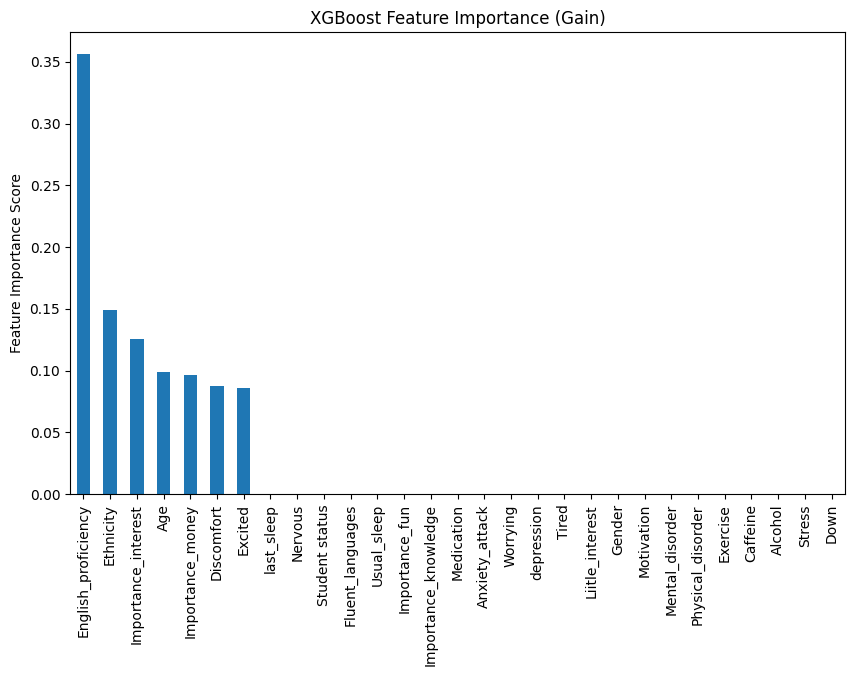


Feature Importance Ranking (Based on Gain):
English_proficiency     0.356033
Ethnicity               0.148955
Importance_interest     0.125763
Age                     0.098972
Importance_money        0.096703
Discomfort              0.087860
Excited                 0.085714
last_sleep              0.000000
Nervous                 0.000000
Student status          0.000000
Fluent_languages        0.000000
Usual_sleep             0.000000
Importance_fun          0.000000
Importance_knowledge    0.000000
Medication              0.000000
Anxiety_attack          0.000000
Worrying                0.000000
depression              0.000000
Tired                   0.000000
Liitle_interest         0.000000
Gender                  0.000000
Motivation              0.000000
Mental_disorder         0.000000
Physical_disorder       0.000000
Exercise                0.000000
Caffeine                0.000000
Alcohol                 0.000000
Stress                  0.000000
Down                    0.00000

In [13]:
# Get importance via XGBoost's built-in method
importance = pd.Series(xgb_reg.feature_importances_, index=X_train.columns)
importance = importance.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importance.plot(kind='bar')
plt.title('XGBoost Feature Importance (Gain)')
plt.ylabel('Feature Importance Score')
plt.show()

print("\nFeature Importance Ranking (Based on Gain):")
print(importance)

# Linear model and MLP

# Linear model: lasso

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import copy
import statsmodels.api as sm
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score

cols = df.columns
cols_list = df.columns.tolist()[1:]
continuous_features = ['Age']+cols_list[2:]
print(continuous_features)
categorical_features = ['Gender']

r2_scores_lasso = []
best_r2_overall = -np.inf

print(f"--- Starting {N_RUNS} runs of Lasso training and evaluation ---")

for i, seed in enumerate(random_states):
    print(f"\n--- Run {i+1}/{N_RUNS} (Random Seed: {seed}) ---")
    
    #Data Split: Sample the data using a different random_state
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=seed  # Crucial: change the seed for each loop
    )

    preprocessor = ColumnTransformer(
    transformers=[
        # Standardize continuous features (StandardScaler)
        ('cont', StandardScaler(), continuous_features),
        # Apply One-Hot Encoding to categorical features (OneHotEncoder)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    # Do not transform any remaining features (if they exist)
    remainder='passthrough'
)

    # Apply preprocessing to the training and test sets
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Get the processed feature names, used for interpreting model coefficients
    feature_names_out = (
        continuous_features + 
        list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
    )
    X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names_out)
    X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names_out)
    
    # LassoCV automatically performs cross-validation to select the optimal alpha (regularization strength)
    print("Starting Lasso Regression tuning (searching for best Alpha)...")
    
    # Use RepeatedKFold to ensure robustness of cross-validation results
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    # LassoCV takes standardized features
    model_lasso_cv = LassoCV(
        cv=cv, 
        random_state=42,
        n_jobs=-1,
        max_iter=10000 # Increase maximum iterations to ensure convergence
    ).fit(X_train_processed.values, y_train)
    
    best_alpha = model_lasso_cv.alpha_
    print(f"Optimal Regularization Strength (Alpha): {best_alpha:.4f}")
    
    # Refit Lasso using the optimal Alpha
    final_lasso = Lasso(alpha=best_alpha, max_iter=10000).fit(X_train_processed, y_train)
    
    # Identify important features selected by Lasso (non-zero coefficients)
    lasso_coefficients = pd.Series(final_lasso.coef_, index=X_train_processed.columns)
    # Filter for features whose absolute coefficient value is greater than a minimal value (e.g., 1e-6)
    selected_features = lasso_coefficients[np.abs(lasso_coefficients) > 1e-6]
    
    print(f"\nNumber of features selected by Lasso: {len(selected_features)} / {len(X_train_processed.columns)}")
    print("--- Weights of Selected Core Features ---")
    print(selected_features.sort_values(ascending=False).to_markdown())
    
    #calculating p-values
    
    # Extract features selected by Lasso for use in the statsmodels OLS model
    if len(selected_features) == 0:
        print("\n⚠️ Warning: Lasso selected no features (or alpha is too large), skipping OLS inference.")
    else:
        X_train_ols = X_train_processed[selected_features.index].copy()
    
        # OLS model requires a constant term (intercept)
        X_train_ols = sm.add_constant(X_train_ols) 
    
        y_train_aligned = y_train.reset_index(drop=True)
        X_train_ols_aligned = X_train_ols.reset_index(drop=True)
    
        # Fit the OLS model and calculate p-values
        ols_model = sm.OLS(y_train_aligned, X_train_ols_aligned).fit()
    
        #Report Final Results
    
        # print("\n" + "=" * 60)
        # print("OLS Model Statistical Inference Results (Only Lasso-Selected Features):")
        # print("=" * 60)
        # print(ols_model.summary())
        # print("=" * 60)
    
        # Evaluate Lasso's performance on the test set
        y_test_pred = final_lasso.predict(X_test_processed)
        test_r2 = r2_score(y_test, y_test_pred)

        print(f"R^2 Score: {test_r2:.4f}")
            
        r2_scores_lasso.append(test_r2)
            
        # Update the best R^2
        if test_r2 > best_r2_overall:
            best_r2_overall = test_r2

#Final Results Summary
r2_mean = np.mean(r2_scores_lasso)
r2_std = np.std(r2_scores_lasso)

print("\n" + "=" * 50)
print(" Final Results Summary (10 Runs) ")
print("=" * 50)
print(f"All R^2 Scores: {np.array(r2_scores_lasso)}")
print(f"Mean R^2: {r2_mean:.4f}")
print(f"R^2 Standard Deviation (SD): {r2_std:.4f}")
print(f"Best R^2: {best_r2_overall:.4f}")
print("=" * 50)
    

['Age', 'English_proficiency', 'Usual_sleep', 'last_sleep', 'Tired', 'Stress', 'Excited', 'Alcohol', 'Caffeine', 'Exercise', 'Physical_disorder', 'Mental_disorder', 'Motivation', 'Down', 'Liitle_interest', 'depression', 'Nervous', 'Worrying', 'Anxiety_attack', 'Medication', 'Discomfort', 'Importance_money', 'Importance_knowledge', 'Importance_fun', 'Importance_interest', 'Fluent_languages', 'Student status', 'Ethnicity']
--- Starting 10 runs of Lasso training and evaluation ---

--- Run 1/10 (Random Seed: 45) ---
Starting Lasso Regression tuning (searching for best Alpha)...
Optimal Regularization Strength (Alpha): 36.5924

Number of features selected by Lasso: 8 / 30
--- Weights of Selected Core Features ---
|                     |         0 |
|:--------------------|----------:|
| Discomfort          |  57.2161  |
| Alcohol             |  35.4147  |
| Importance_money    |  22.037   |
| Ethnicity           |  14.0753  |
| Importance_fun      |   9.16573 |
| Fluent_languages    |  -2.5

# MLP

In [11]:
# Build the MLP Model
class RegressionMLP(nn.Module):
    def __init__(self, input_dim):
        super(RegressionMLP, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            # nn.Linear(64, 64),
            # nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)


# ncapsulate "Learner" Training and Evaluation Logic (with Early Stopping)

def fit_and_evaluate_with_early_stop(model, train_loader, test_loader, loss_fn, optimizer, epochs, patience=20):
    
    best_val_loss = float('inf')  # Initialize the best validation loss to infinity
    patience_counter = 0          # Early stopping counter
    best_model_wts = None         # To store the best model weights
    
    print(f"Starting PyTorch MLP model training with early stopping patience: {patience} epochs...")
    
    for epoch in range(1, epochs + 1):
        # Training phase
        model.train()
        total_train_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Evaluation phase (Validation)
        model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for X_test_batch, y_test_batch in test_loader:
                pred = model(X_test_batch)
                all_preds.append(pred.numpy())
                all_targets.append(y_test_batch.numpy())

        preds_flat = np.concatenate(all_preds).flatten()
        targets_flat = np.concatenate(all_targets).flatten()
        val_mse = mean_squared_error(targets_flat, preds_flat)
        val_rmse = np.sqrt(val_mse)
        val_r2 = r2_score(targets_flat, preds_flat)
        
        #Early Stopping
        if val_mse < best_val_loss:
            best_val_loss = val_mse
            patience_counter = 0  # Reset counter
            # Save the best model weights
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"Epoch {epoch:03d} | Train Loss (Avg): {total_train_loss / len(train_loader):.2f} | "
                  f"Val MSE: {val_mse:.2f} | Val R²: {val_r2:.4f} * (Best Model Saved)")
        else:
            patience_counter += 1
            print(f"Epoch {epoch:03d} | Train Loss (Avg): {total_train_loss / len(train_loader):.2f} | "
                  f"Val MSE: {val_mse:.2f} | Val R²: {val_r2:.4f} | Patience: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print(f"\n--- Early Stopping Triggered: Validation performance did not improve for {patience} consecutive Epochs.---")
                break
    # Load the best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    
    # Re-evaluate and return final metrics (using the best weights)
    final_mse, final_rmse, final_r2 = test_loop(model, test_loader)
    return final_mse, final_rmse, final_r2 

def test_loop(model, dataloader):
    """Helper function to run final evaluation on best model."""
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            total_loss += nn.MSELoss()(pred, y).item()
            all_preds.append(pred.numpy())
            all_targets.append(y.numpy())
            
    preds_flat = np.concatenate(all_preds).flatten()
    targets_flat = np.concatenate(all_targets).flatten()
    final_mse = total_loss / len(dataloader)
    final_rmse = np.sqrt(final_mse)
    final_r2 = r2_score(targets_flat, preds_flat)
    return final_mse, final_rmse, final_r2

In [ ]:
#Data Transformation

# Initialize lists and variables for multiple runs
r2_scores_mlp = []
best_r2_overall = -np.inf
#random_states = [42]

print(f"--- Starting {N_RUNS} runs of MLP training and evaluation ---")

for i, seed in enumerate(random_states):
    print(f"\n--- Run {i+1}/{N_RUNS} (Random Seed: {seed}) ---")
    
    # 1. Data Split: Sample the data using a different random_state
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=seed  # Crucial: change the seed for each loop
    )

    preprocessor = ColumnTransformer(
    transformers=[
        # Standardize continuous features (StandardScaler)
        ('cont', StandardScaler(), continuous_features),
        # Apply One-Hot Encoding to categorical features (OneHotEncoder)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    # Do not transform any remaining features (if they exist)
    remainder='passthrough'
)

    # Apply preprocessing to the training and test sets
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names_out)
    X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names_out)
    
    # Convert processed features and target variables to NumPy arrays
    X_train_np = X_train_processed.values.astype(np.float32)
    X_test_np = X_test_processed.values.astype(np.float32)
    y_train_np = y_train.values.astype(np.float32).reshape(-1, 1)
    y_test_np = y_test.values.astype(np.float32).reshape(-1, 1)
    
    # Convert to PyTorch Tensors
    X_train_tensor = torch.from_numpy(X_train_np)
    y_train_tensor = torch.from_numpy(y_train_np)
    X_test_tensor = torch.from_numpy(X_test_np)
    y_test_tensor = torch.from_numpy(y_test_np)
    
    # Create Dataset and DataLoader for batch training
    BATCH_SIZE = 64
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Get the number of input features
    input_size = X_train_tensor.shape[1]
    # Run model

    model = RegressionMLP(input_size)
    loss_fn = nn.MSELoss() 
    # Note: We add L2 regularization (weight_decay) to the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.00025, weight_decay=1e-5) 
    EPOCHS = 5000 # Set a large number of epochs and let early stopping control the actual training time
    
    final_mse, final_rmse, final_r2 = fit_and_evaluate_with_early_stop(
        model, 
        train_loader, 
        test_loader, 
        loss_fn, 
        optimizer, 
        EPOCHS,
        patience=400 # Tolerance for no improvement over 400 epochs
    )
    print(f"R^2 Score: {final_r2:.4f}")
            
    r2_scores_mlp.append(final_r2)
            
    # Update the best R^2
    if final_r2 > best_r2_overall:
        best_r2_overall = final_r2

r2_mean = np.mean(r2_scores_mlp)
r2_std = np.std(r2_scores_mlp)

print("\n" + "=" * 50)
print(" Final Results Summary (10 Runs) ")
print("=" * 50)
print(f"All R^2 Scores: {np.array(r2_scores_mlp)}")
print(f"Mean R^2: {r2_mean:.4f}")
print(f"R^2 Standard Deviation (SD): {r2_std:.4f}")
print(f"Best R^2: {best_r2_overall:.4f}")
print("=" * 50)

# Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data into a single DataFrame for easier seaborn plotting
data = {
    'R^2 Score': r2_scores_XGB + r2_scores_lasso + r2_scores_mlp,
    'Model': 
        ['XGBoost'] * len(r2_scores_XGB) + 
        ['Lasso'] * len(r2_scores_lasso) + 
        ['MLP'] * len(r2_scores_mlp)
}
df_r2 = pd.DataFrame(data)

# Calculate the mean R^2 for each model, for annotation (no longer needed as barplot calculates it automatically)
# mean_r2 = df_r2.groupby('Model')['R^2 Score'].mean().reset_index()

# Set plotting style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Define colors
palette = {"XGBoost": "skyblue", "Lasso": "lightcoral", "MLP": "mediumseagreen"}

# Display Mean R^2 using a Bar Plot
# Removed err_kws to avoid version compatibility issues
sns.barplot(
    x='Model', 
    y='R^2 Score', 
    data=df_r2, 
    palette=palette,
    errorbar=('sd'), # Add standard deviation error bars
    capsize=0.05     # Size of the error bar caps
)

# Add all 10 data points (scatter plot) using Strip Plot
# Set color to grey or black and adjust transparency so it's above the bar plot but not overly prominent
sns.stripplot(
    x='Model', 
    y='R^2 Score', 
    data=df_r2, 
    color='darkslategrey', # Use dark grey
    size=6, 
    jitter=True, # Add slight jitter to prevent point overlap
    alpha=0.7,
    linewidth=0.5, # Add point border
    edgecolor='white'
)

# add a horizontal line at R^2 = 0
plt.axhline(0, color='red', linestyle='-', linewidth=1, label='$R^2 = 0$ Baseline')

# Set chart title and labels
plt.title('Performance Comparison of Regression Models on Quote Dataset ($R^2$ Score)', fontsize=14, fontweight='bold')
plt.xlabel('Regression Model', fontsize=12)
plt.ylabel('Coefficient of Determination ($R^2$)', fontsize=12)

# Remove top and right spines
sns.despine(trim=True)

# Ensure Y-axis includes all data points and the baseline
min_val = df_r2['R^2 Score'].min() - 0.05
max_val = df_r2['R^2 Score'].max() + 0.15 # Leave space for annotations
plt.ylim(min_val, max_val)

plt.savefig('R2_Model_Comparison.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


Table successfully saved as image: Transfer_R2_Comparison_Table.png (300 DPI)


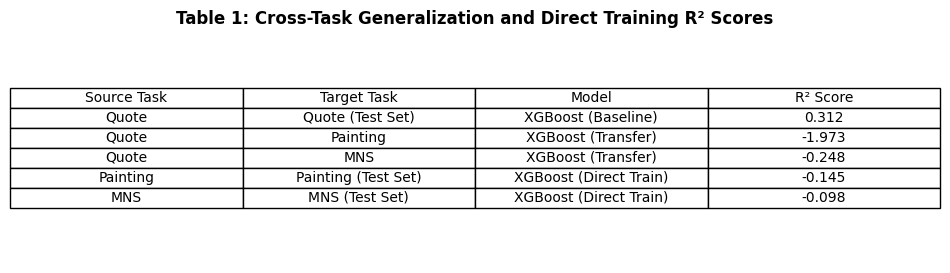

In [4]:
# Transferability Result
results_data = {
    'Source Task': [
        'Quote', 
        'Quote', 
        'Quote', 
        'Painting', 
        'MNS'
    ],
    'Target Task': [
        'Quote (Test Set)',
        'Painting', 
        'MNS', 
        'Painting (Test Set)', 
        'MNS (Test Set)'
    ],
    'Model Type': [
        'XGBoost (Baseline)',
        'XGBoost (Transfer)', 
        'XGBoost (Transfer)', 
        'XGBoost (Direct Train)', 
        'XGBoost (Direct Train)'
    ],
    'R2 Score': [
        0.3116,   
        -1.9732,
        -0.2483,
        -0.1451,
        -0.0981
    ]
}

df_transfer = pd.DataFrame(results_data)

# Round R2 Score for clean presentation
df_transfer['R2 Score'] = df_transfer['R2 Score'].round(3)

# Rename columns for final paper presentation
df_transfer.columns = [
    'Source Task', 
    'Target Task', 
    'Model', 
    'R² Score'
]

# Generate Table Image using Matplotlib

# Prepare data for plotting
cell_data = df_transfer.values.tolist()
col_labels = df_transfer.columns.tolist()

# Define table title
table_title = 'Table 1: Cross-Task Generalization and Direct Training R² Scores'

# Set up figure and axes
# Adjusted figure size for better table appearance
fig, ax = plt.subplots(figsize=(10, 3)) 

# Hide axes (no X/Y axes needed for a table)
ax.axis('off') 
ax.axis('tight') 

# Create the table
table = ax.table(
    cellText=cell_data, 
    colLabels=col_labels, 
    loc='center', 
    cellLoc='center'
)

# Set properties for better visual appeal
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2) # Scale the table slightly for better spacing

# Add title
plt.title(table_title, y=1.0, fontsize=12, fontweight='bold')

# Save the table as an image file
table_filename = 'Transfer_R2_Comparison_Table.png'
plt.savefig(table_filename, dpi=300, bbox_inches='tight')

print(f"\nTable successfully saved as image: {table_filename} (300 DPI)")

# Display the table
plt.show()